# An infinite sum of Poisson-weighted convolutions

Kyle Cranmer, Aug 2018

If viewing on GitHub, this looks better with nbviewer: [click here](http://nbviewer.jupyter.org/github/cranmer/poisson-convolution-sum/blob/master/Poisson-weighted-convolutions.ipynb)

Consider a variable $x = \sum_{i=1}^n z_i$, where the $z_i \sim p(z|\theta)$ are iid and $n \sim Pois(\nu)$. For each value of $n$, the distribution $p(x|n)$ is given by repeated convolutions
\begin{equation}
{p(x|n, \theta)} = p(z|\theta)\underbrace{\star \dots \star}_\text{n times} p(z|\theta)
\end{equation}
and for a Poisson mean of $\nu$ the expected distribution for $x$ is  
\begin{equation}
{p(x|\nu, \theta)} = \sum_{n=0}^\infty e^{-\nu} \frac{\nu^n}{n!} p(x|n, \theta)
\end{equation}

The infinite tower of Poisson-weighted convolutions can be computed efficiently with a nice trick documented in *Analytic Confidence Level Calculations using the Likelihood Ratio and Fourier Transform* by Hongbo Hu and Jason Nielsen https://arxiv.org/pdf/physics/9906010.pdf. See also [this old paper](https://arxiv.org/abs/physics/0312050) and this [code](http://phystat.org/phystat/packages/0703002.1.html) for a C++ implementation.

First we take advantage of the convolution theorem relating convolutions to multiplication in the Fourier domain, denoted with a bar.
\begin{equation}
\overline{p(x|n, \theta)} = \overline{p(z|\theta)\underbrace{\star \dots \star}_\text{n times} z|\theta} = \left[\overline{p(z|\theta)} \right]^n 
\end{equation}
and then we can compress the infinite sum into the following exponential
\begin{equation}
\overline{p(x|\nu, \theta)} = \sum_{n=0}^\infty e^{-\nu} \frac{\nu^n}{n!}  \overline{p(x|n)}  =  \exp\left( \nu \left[ \overline{p(z|\theta)}-1 \right] \right)
\end{equation}

In the code below, we will reimplement the technique using pytorch. An interesting feature of implementing this in pytorch is that we can backprop through the inverse FFT, the exponentiation, the multplication, the subtraction, and forward FFT to calculate the gradient
\begin{equation}
\nabla_\theta\, p(x|\nu, \theta)
\end{equation}
and 
\begin{equation}
\nabla_\nu \, p(x|\nu, \theta)
\end{equation}.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Warmup: Gaussian$\bigoplus$ Gaussian complex FFT 

In [2]:
# for Nx2 tensors
def complex_multiplication(t1, t2):
  real1, imag1 = t1.t()
  real2, imag2 = t2.t()
  return torch.stack([real1 * real2 - imag1 * imag2, real1 * imag2 + imag1 * real2], dim = -1)

In [3]:
min_=0
max_=5
nbins = 1000
x = torch.arange(min_, max_,(max_-min_)/nbins, dtype=torch.double)
x=x.view(-1,nbins)
x.shape

gamma = torch.ones(1,1, requires_grad=True)
#gamma[0,0]=3
gamma = torch.ones(1,1, requires_grad=True, dtype=torch.double)
sigma = 0.05


y = torch.empty(1,nbins,2)
y[0,:,0] = torch.exp(-(x-gamma)*(x-gamma)/2/sigma/sigma)*(1./np.sqrt(2.*np.pi)/sigma)*max_/nbins
y[0,:,1]= torch.zeros(nbins)

yfft = torch.fft(y,1,normalized=False)
#y2fft = yfft*yfft
y2fft = complex_multiplication(yfft[0],yfft[0]).view(-1,nbins,2)
y3fft = complex_multiplication(yfft[0],y2fft[0]).view(-1,nbins,2)
#y2fft = yfft
y2 = torch.ifft(y2fft,1, normalized=False)
y3 = torch.ifft(y3fft,1, normalized=False)

print(y2.shape)

#y2.backward(torch.ones_like(y2))

#print(gamma.grad)

print(torch.sum(y))
#yfft

torch.Size([1, 1000, 2])
tensor(1.)


(0.5773504, 0.5773502691896258)

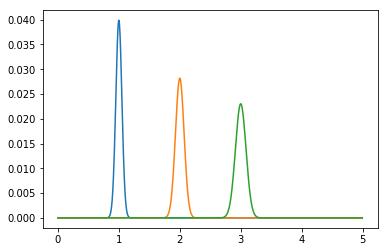

In [4]:
with torch.no_grad():
    plt.plot(x[0].detach().numpy(),y[0,:,0].detach().numpy())
    plt.plot(x[0].detach().numpy(),y2[0,:,0].detach().numpy())
    plt.plot(x[0].detach().numpy(),y3[0,:,0].detach().numpy())

    
np.max(y2[0,:,0].detach().numpy())/np.max(y[0,:,0].detach().numpy()), 1/np.sqrt(2)
np.max(y3[0,:,0].detach().numpy())/np.max(y[0,:,0].detach().numpy()), 1/np.sqrt(3)

## Poisson convolutions with complex FFT 

(long debugging for pytorch FFT normalization. Need to cleanup and demonstrate the gradients)

In [3]:
def complex_exp_pois(z, nu):
    real1, imag1 = z.t()
    real1=real1-1.
    real_out = torch.exp(real1*nu)*torch.cos(nu*imag1)
    imag_out = torch.exp(real1*nu)*torch.sin(nu*imag1)
    return torch.stack([real_out, imag_out], dim = -1)

In [4]:
def pois_conv(y, nu):
    pass

c base_dist(x)

SyntaxError: invalid syntax (<ipython-input-4-cd782bef5aa5>, line 4)

In [91]:
min_=0
max_=15
nbins=3000
x = torch.arange(min_, max_,(max_-min_)/nbins, dtype=torch.double)
x=x.view(-1,nbins)
x.shape

theta = torch.ones(1,1, requires_grad=True, dtype=torch.double)
nu = torch.tensor(3.,requires_grad=True, dtype=torch.double)
sigma = torch.tensor(0.051,requires_grad=True, dtype=torch.double)
norm = torch.tensor(max_/nbins/np.sqrt(2.*np.pi), dtype=torch.double)/sigma
y = torch.empty(1,nbins,2, dtype=torch.double)
y[0,:,0] = (torch.exp(-(x-theta)*(x-theta)/2./sigma/sigma))*norm
y[0,:,1]= torch.zeros(nbins)

yfft = torch.fft(y,1,normalized=False)
#y2fft = yfft*yfft
y2fft = complex_exp_pois(yfft[0], nu=nu).view(-1,nbins,2)
y2 = torch.ifft(y2fft,1, normalized=False)

y2.backward(torch.ones_like(y2))

print("grad : ", theta.grad)

print(torch.sum(y), torch.sum(y2))

grad :  tensor(1.00000e-15 *
       [[-4.9169]], dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(1.0000, dtype=torch.float64)


In [5]:
def myfact(xin):
    return [np.math.factorial(x) for x in xin]
myfact(np.arange(4))

[1, 1, 2, 6]

In [93]:
# Poisson probs
xint = np.arange(min_, max_)
pois = np.exp(-nu.item())*np.power(nu.item(),xint)/myfact(xint)
scaled_pois = pois
#heights of Gaussian bumps will be lower by width of Gaussian, which scales like sqrt(x()
scaled_pois[1:]= scaled_pois[1:]/np.sqrt(xint[1:])/np.sqrt(2*np.pi)/sigma.item()*max_/nbins

3.5
4.0


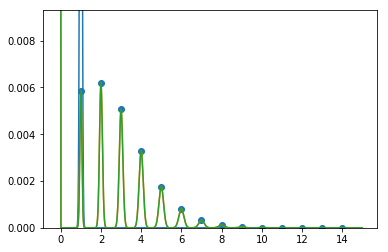

In [95]:
with torch.no_grad():
    print(nu.item())
    plt.plot(x[0].detach().numpy(),y[0,:,0].detach().numpy())
    plt.plot(x[0].detach().numpy(),y2[0,:,0].detach().numpy())
    plt.scatter(xint,scaled_pois)
    plt.ylim(0,np.max(1.5*y2[0,1:,0].detach().numpy()))

    with torch.no_grad():
        nu+=0.5
        nu.grad.zero_()
    print(nu.item())
    plt.plot(x[0].detach().numpy(),y2[0,:,0].detach().numpy())



## With classes

In [17]:
class base_dist():
    def __init__(self):
        self.theta = torch.ones(1,1, requires_grad=True, dtype=torch.double)
        self.sigma = torch.tensor(0.051,requires_grad=True, dtype=torch.double)        
    def forward(self, x):
        max_ = torch.max(x)
        min_ = torch.min(x)
        nbins = x.size()[1]
        norm = torch.tensor(max_/nbins/np.sqrt(2.*np.pi), dtype=torch.double)/self.sigma
        y = torch.empty(1,nbins,2, dtype=torch.double)
        y[0,:,0] = (torch.exp(-(x-self.theta)*(x-self.theta)/2./self.sigma/self.sigma))*norm
        y[0,:,1]= torch.zeros(nbins)
        return y
    def parameters(self):
        return [self.theta, self.sigma]

In [18]:
class pois_conv():
    def __init__(self):
        self.nu = torch.tensor(3.,requires_grad=True, dtype=torch.double)
        self.base_dist = base_dist()
    def forward(self, x):
        y = self.base_dist.forward(x)
        yfft = torch.fft(y,1,normalized=False)
        y2fft = complex_exp_pois(yfft[0], nu=self.nu).view(-1,nbins,2)
        y2 = torch.ifft(y2fft,1, normalized=False)
        return y2
    def parameters(self):
        temp = list(self.base_dist.parameters())
        temp.append(self.nu)
        return temp


In [19]:
min_=0
max_=15
nbins=3000

x = torch.arange(min_, max_,(max_-min_)/nbins, dtype=torch.double)
x=x.view(-1,nbins)

In [39]:
y2_ = pois_conv()
y2_.parameters()
y_ = y2_.base_dist
y2_.forward(x)
y2_.parameters()

[tensor([[ 1.]], dtype=torch.float64), tensor(1.00000e-02 *
        5.1000, dtype=torch.float64), tensor(3., dtype=torch.float64)]

In [40]:
# Poisson probs
nu = y2_.nu
xint = np.arange(min_, max_)
pois = np.exp(-nu.item())*np.power(nu.item(),xint)/myfact(xint)
scaled_pois = pois
#heights of Gaussian bumps will be lower by width of Gaussian, which scales like sqrt(x()
scaled_pois[1:]= scaled_pois[1:]/np.sqrt(xint[1:])/np.sqrt(2*np.pi)/y_.sigma.item()*max_/nbins

3.0
6.0


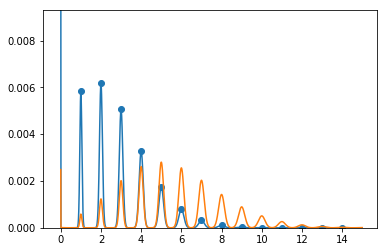

In [41]:
with torch.no_grad():
    print(y2_.nu.item())
    #plt.plot(x[0].detach().numpy(),y_.forward(x)[0,:,0].detach().numpy())
    plt.plot(x[0].detach().numpy(),y2_.forward(x)[0,:,0].detach().numpy())
    plt.scatter(xint,scaled_pois)
    plt.ylim(0,np.max(1.5*y2_.forward(x)[0,1:,0].detach().numpy()))

    with torch.no_grad():
        y2_.nu+=3
    print(y2_.nu.item())
    plt.plot(x[0].detach().numpy(),y2_.forward(x)[0,:,0].detach().numpy())




In [42]:
y2_ = pois_conv()
print(y2_.nu.item())
temp_y2_at_3 = y2_.forward(x)
with torch.no_grad():
    y2_.nu+=0.01
    print(y2_.nu.item())
temp_y2_at_3_plus_delta = y2_.forward(x)
epsilon = temp_y2_at_3_plus_delta-temp_y2_at_3
torch.max(epsilon), torch.max(temp_y2_at_3_plus_delta), torch.max(temp_y2_at_3)


3.0
3.01


(tensor(1.00000e-05 *
        1.1727, dtype=torch.float64), tensor(1.00000e-02 *
        4.9292, dtype=torch.float64), tensor(1.00000e-02 *
        4.9787, dtype=torch.float64))

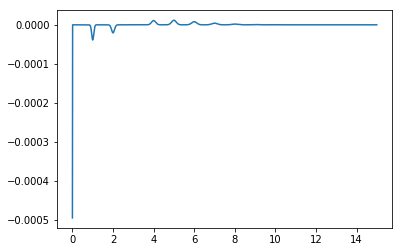

In [43]:
with torch.no_grad():
    plt.plot(x[0].detach().numpy(),epsilon[0,:,0].detach().numpy())

In [44]:
with torch.no_grad():
    y2_.nu-=0.01 # put it back
out = y2_.forward(x)
out.backward(epsilon)
y2_.nu.grad, y2_.base_dist.sigma.grad, y2_.base_dist.theta.grad

(tensor(1.00000e-05 *
        2.9869, dtype=torch.float64), tensor(1.00000e-05 *
        4.8010, dtype=torch.float64), tensor(1.00000e-12 *
        [[ 3.9466]], dtype=torch.float64))